In [48]:
import torch
from genwarp import GenWarp

genwarp_cfg = dict(
    pretrained_model_path='./checkpoints',
    checkpoint_name='multi1',
    half_precision_weights=False
)
genwarp_nvs = GenWarp(cfg=genwarp_cfg)

# Load MDE model.
depth_estimator = torch.hub.load(
    './extern/ZoeDepth',
    'ZoeD_N',
    source='local',
    pretrained=True,
    trust_repo=True
).to('cuda')

Loading GenWarp...


/home/nsml/.local/lib/python3.8/site-packages/diffusers/models/lora.py:306: FutureWarning: `LoRACompatibleConv` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleConv` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleConv", "1.0.0", deprecation_message)


Loaded GenWarp.
img_size [384, 512]


Using cache found in /home/nsml/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [70]:
from PIL import Image
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import ToPILImage

to_img = ToPILImage()

image_file = "/mnt/image-net-full/j1nhwa.kim/interns/minseop.kwak/RealEstate10K_Downloader/dataset/train/0a9e82926ed00bec/46946900.png"
src_image = to_tensor(Image.open(image_file).convert('RGB'))[None].cuda()
src_depth = depth_estimator.infer(src_image)

tensor([[[[0.5315, 0.5326, 0.5336,  ..., 0.5829, 0.5817, 0.5805],
          [0.5342, 0.5353, 0.5364,  ..., 0.5862, 0.5850, 0.5838],
          [0.5369, 0.5380, 0.5391,  ..., 0.5894, 0.5883, 0.5871],
          ...,
          [0.2419, 0.2421, 0.2423,  ..., 0.2691, 0.2687, 0.2683],
          [0.2400, 0.2402, 0.2404,  ..., 0.2689, 0.2686, 0.2682],
          [0.2385, 0.2387, 0.2389,  ..., 0.2688, 0.2684, 0.2681]]]],
       device='cuda:0', grad_fn=<DivBackward0>)


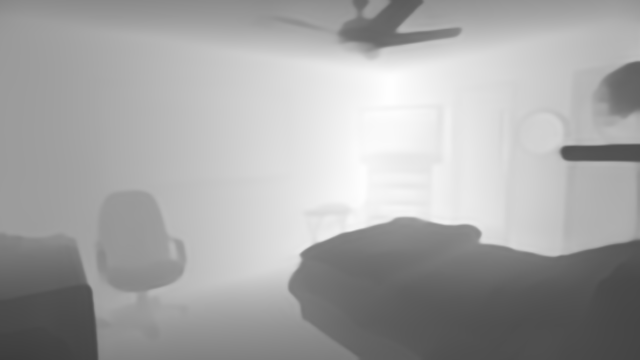

In [71]:
print(src_depth / src_depth.max())
to_img(src_depth[0] / src_depth.max())

In [72]:
from genwarp.ops import camera_lookat, get_projection_matrix

device = src_depth.device

print(device)

fovy = torch.tensor([1.0472]).to(device)
near = 0.8
far = 6.7

proj_mtx = get_projection_matrix(
    fovy=fovy,
    aspect_wh=1.,
    near=near,
    far=far
).to(device).float()

src_view_mtx = camera_lookat(
    torch.tensor([[0., 0., 0.]]).to(device),  # From (0, 0, 0)
    torch.tensor([[-1., 0., 0.]]).to(device), # Cast rays to -x
    torch.tensor([[0., 0., 1.]]).to(device)   # z-up
).to(device).float()

# tar_view_mtx = camera_lookat(
#     torch.tensor([[0., 0., 0.]]).to(device),  # From (0, 0, 0)
#     torch.tensor([[-1., 0., 0.]]).to(device), # Cast rays to -x
#     torch.tensor([[0., 0., 1.]]).to(device)   # z-up
# ).to(device).float()

tar_view_mtx = camera_lookat(
    torch.tensor([[-0.1, 2., 1.]]).to(device), # Camera eye position
    torch.tensor([[-5., 0., 0.]]).to(device),  # Looking at.
    torch.tensor([[0., 0., 1.]]).to(device),  # z-up
).to(device).float()


rel_view_mtx = (
    tar_view_mtx.float() @ torch.linalg.inv(src_view_mtx.float().to(device))
).float()

# .to(src_image)

cuda:0


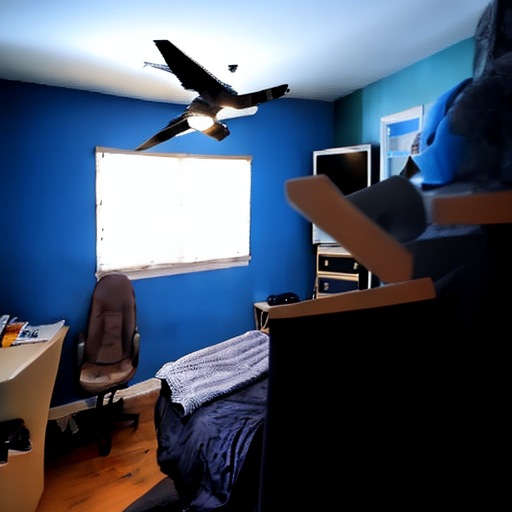

In [73]:
renders = genwarp_nvs(
    src_image=src_image,
    src_depth=src_depth,
    rel_view_mtx=rel_view_mtx,
    src_proj_mtx=proj_mtx,
    tar_proj_mtx=proj_mtx
)

# Outputs.
renders['synthesized']     # Generated image.
renders['warped']          # Depth based warping image (for comparison).
renders['mask']            # Mask image (mask=1 where visible pixels).
renders['correspondence']  # Correspondence map.

to_img(renders['synthesized'][0])

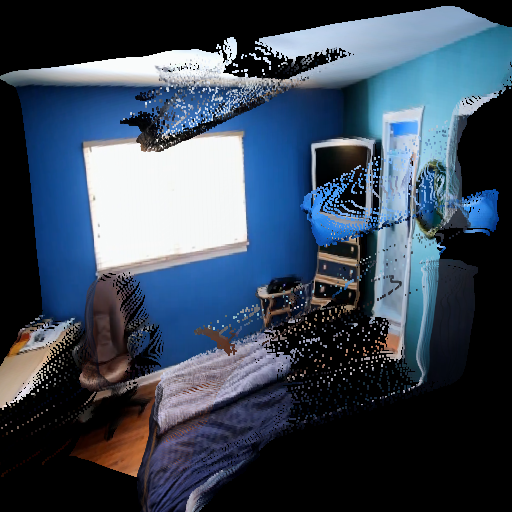

In [74]:
to_img(renders['warped'][0])